# CNN Simples v2

## Pipeline do Projeto

1. Importação das bibliotecas

2. Carregamento e visualização do dataset

3. Pré-processamento das imagens

4. Criação do modelo CNN simples

5. Treinamento e validação do modelo

6. Análise de desempenho

7. (Próximos notebooks) Ajustes para correção de overfitting e uso de MobileNet

Claro! Aqui estão as **melhorias** aplicadas na versão **CNN Simples v2**, em relação à versão anterior:

---

### 🔧 **1. Normalização e Data Augmentation**

**Melhoria**: aumentamos a variabilidade do treino sem adicionar novas imagens.

```python
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)  # normalização embutida aqui
])
```

---

### 🧱 **2. Arquitetura CNN aprimorada**

**Melhoria**: inserimos camadas modernas que ajudam a estabilizar e generalizar o modelo:

* **BatchNormalization**: acelera o treino e melhora a performance
* **Dropout**: previne overfitting
* **GlobalAveragePooling2D**: reduz drasticamente os parâmetros antes da camada densa

```python
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=image_shape),
    data_augmentation,
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
```

---

### ⏱️ **3. Callbacks inteligentes**

**Melhoria**: controle automático do treino com:

* **EarlyStopping**: para o treino se não melhorar por algumas épocas
* **ReduceLROnPlateau**: reduz a taxa de aprendizado ao detectar platôs

```python
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2)
]
```

---

### 🧪 **4. Avaliação completa**

Incluímos todos os indicadores:

* Acurácia
* F1-score ponderado
* Log Loss
* Tempo médio de inferência por imagem
* Matriz de confusão
* Relatório de classificação por classe

---

### 💾 **5. Salvamento para comparação**

O modelo e as métricas foram salvos para facilitar a comparação com:

* Logistic Regression
* Naive Bayes
* Random Forest
* SVM
* CNN Simples v1

---


# 0 Importação das bibliotecas

In [17]:
import os
import time
import numpy as np
import joblib
import json
import random
from datetime import timedelta


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    log_loss, 
    accuracy_score, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize

In [4]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Definição dos parâmetros

In [5]:
# Tamanho das imagens e diretório base
image_width = 244
image_height = 244
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)
batch_size = 32

base_dir = './datasets/Plastic_Classification/'

# 2 Carregamento e visualização do dataset

In [6]:
# Carregar conjunto de treino com labels categóricos (one-hot)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Obter nomes das classes
class_names = train_ds_raw.class_names

# Aplicar prefetch
# Aplicar prefetch para desempenho
train_ds = train_ds_raw.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False # Excelente manter shuffle=False no teste, pois precisaremos da ordem para calcular métricas e exibir previsões reais vs. preditas.
).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1441 files belonging to 7 classes.
Found 416 files belonging to 7 classes.
Found 209 files belonging to 7 classes.


In [7]:
def plot_sample_images(dataset, class_names, n=9):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.suptitle("Exemplos de imagens do conjunto de treino", fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
for images, labels in train_ds.take(1):
    print("Formato das imagens:", images.shape)
    print("Rótulos:", labels.numpy())

Formato das imagens: (32, 244, 244, 3)
Rótulos: [[0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [9]:
for images, labels in train_ds.take(1):
    label_indices = tf.argmax(labels, axis=1).numpy()
    class_labels = [class_names[i] for i in label_indices]
    print("Rótulos decodificados:", class_labels)

Rótulos decodificados: ['HDPE', 'PP', 'HDPE', 'LDPA', 'LDPA', 'PP', 'PP', 'PVC', 'PET', 'PVC', 'LDPA', 'PET', 'PVC', 'LDPA', 'LDPA', 'PVC', 'HDPE', 'Other', 'Other', 'HDPE', 'Other', 'LDPA', 'PET', 'PS', 'HDPE', 'PET', 'PVC', 'LDPA', 'LDPA', 'PVC', 'PP', 'PS']


## Aplicar data_augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),                      # força o tamanho fixo
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),  # brilho aleatório
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))  # garante que fique entre [0,1]
], name="data_augmentation")



In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


## Montar o modelo CNN simples v2

Incluindo:

- data_augmentation

- normalization_layer

- Camadas convolucionais e de pooling

- Dropout para evitar overfitting

- Dense final com softmax

In [12]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=image_shape),
    data_augmentation,                      # Aplicação no modelo
    normalization_layer,                    # Normalização entre 0 e 1

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Saída com softmax
], name="CNN_Simples_v2")



## Compilar o modelo
Com otimizador adam, função categorical_crossentropy e métrica accuracy.

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
model.summary()

Model: "CNN_Simples_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,335 (49.36 MB)

 Trainable params: 12,939,335 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## Treinar o modelo

In [18]:
# Tempo de treino
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Tempo de treinamento
training_time = time.time() - start_time
print("\nTempo de treinamento:", str(timedelta(seconds=int(training_time))))


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 386s 8s/step - accuracy: 0.1337 - loss: 1.9461 - val_accuracy: 0.1442 - val_loss: 1.9459
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 394s 7s/step - accuracy: 0.1232 - loss: 1.9463 - val_accuracy: 0.1442 - val_loss: 1.9459
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.1349 - loss: 1.9462 - val_accuracy: 0.1442 - val_loss: 1.9459
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.1433 - loss: 1.9462 - val_accuracy: 0.1442 - val_loss: 1.9459

Tempo de treinamento: 0:25:35


In [19]:
# Avaliação
loss, acc = model.evaluate(test_ds)
print(f"\nAcurácia no conjunto de teste: {acc:.2f}")
print(f'\nAvaliação no conjunto de teste:\n - Loss: {loss:.4f}\n - Acurácia: {acc:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 757ms/step - accuracy: 0.0443 - loss: 1.9471

Acurácia no conjunto de teste: 0.14

Avaliação no conjunto de teste:
 - Loss: 1.9459
 - Acurácia: 0.1435


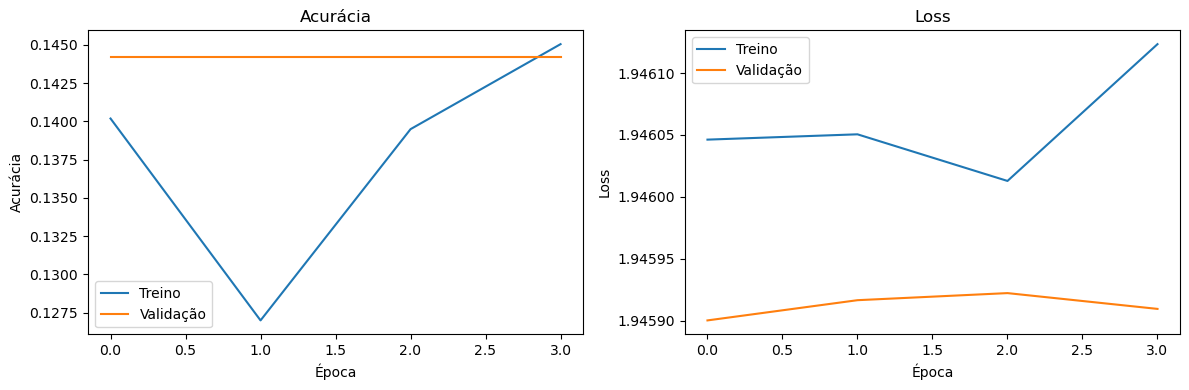

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Avaliar modelo no conjunto de teste

In [23]:
# Caso y_true ou y_pred estejam em one-hot encoding, converta assim:
y_true_labels = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
y_pred_labels = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

# Agora gere o relatório corretamente
print("\n Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))




 Classification Report:



C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

        HDPE       0.00      0.00      0.00        30
        LDPA       0.00      0.00      0.00        30
       Other       0.00      0.00      0.00        30
         PET       0.00      0.00      0.00        29
          PP       0.00      0.00      0.00        30
          PS       0.00      0.00      0.00        30
         PVC       0.14      1.00      0.25        30

    accuracy                           0.14       209
   macro avg       0.02      0.14      0.04       209
weighted avg       0.02      0.14      0.04       209



C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [26]:
# Exemplo: class_names = ['PET', 'PP', 'PS', 'PVC']
y_true_labels = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
y_pred_labels = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

# Convertendo índices para nomes das classes
y_true_cat = [class_names[i] for i in y_true_labels]
y_pred_cat = [class_names[i] for i in y_pred_labels]


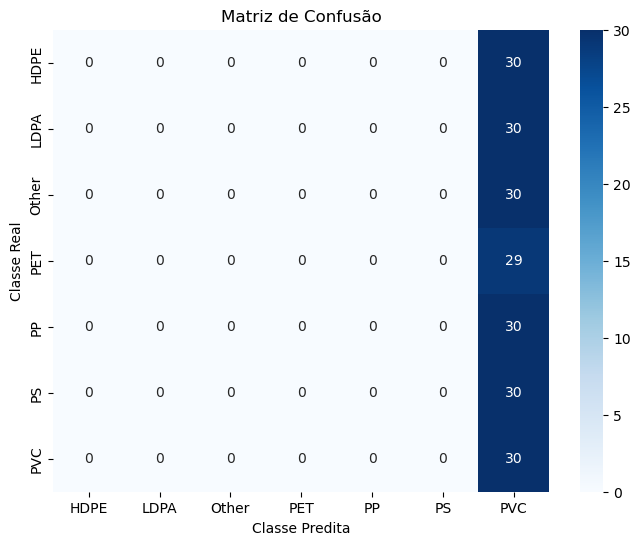

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=class_names)

# Plotar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()


## Curva ROC Multiclasse

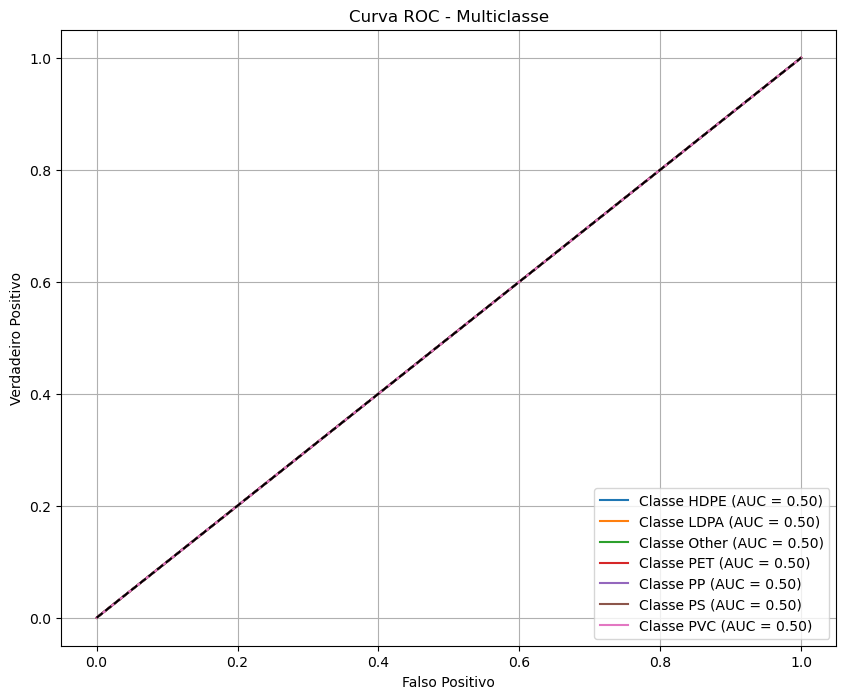

In [29]:
# Binarizar as labels
y_test_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_test_bin.shape[1]

# Curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar ROC multiclasses
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC - Multiclasse")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Salvar modelo e métricas

In [ ]:
os.makedirs("models/06_cnn_v2", exist_ok=True)
model.save("models/06_cnn_v2/cnn_v2_model.keras")

with open("models/06_cnn_v2/cnn_v2_metrics.json", "w") as f:
    json.dump({
        "model": "cnn_v2",
        "accuracy": acc,
        "f1_score_weighted": f1,
        "log_loss": loss_val,
        "train_time_sec": train_time,
        "inference_time_ms": inference_time
    }, f)

print("\nModelo e métricas salvos com sucesso!")